# Perbandingan exact NN dengan ANNOY

## Data random 2D dengan 1000 data poin

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from annoy import AnnoyIndex

# 1. Dataset 2D
np.random.seed(42)
n_points = 1000
X = np.random.rand(n_points, 2) * 100  # titik random dalam ruang 100x100

# Query point (ambil salah satu titik random)
query = X[np.random.randint(0, n_points)]

# 2. Exact NN (brute force)
start = time.time()
distances = np.linalg.norm(X - query, axis=1)
idx_exact = np.argsort(distances)[:3]  # ambil 3 terdekat
time_exact = time.time() - start

print("Exact NN index:", idx_exact)
print("Exact NN jarak:", distances[idx_exact])
print("Waktu Exact:", round(time_exact*1000, 4), "ms")

Exact NN index: [219 898 593]
Exact NN jarak: [0.         1.36915938 2.27931544]
Waktu Exact: 0.0 ms


In [2]:
# 3. Annoy NN (3 tree)
f = 2  # dimensi
t = AnnoyIndex(f, 'euclidean')
for i, vec in enumerate(X):
    t.add_item(i, vec)

t.build(3)  # 3 trees

start = time.time()
idx_ann = t.get_nns_by_vector(query, 3)  # cari 3 NN
time_ann = time.time() - start

print("\nAnnoy NN index:", idx_ann)
print("Annoy NN jarak:", [np.linalg.norm(X[i]-query) for i in idx_ann])
print("Waktu Annoy:", round(time_ann*1000, 4), "ms")


Annoy NN index: [219, 898, 770]
Annoy NN jarak: [np.float64(0.0), np.float64(1.369159376273702), np.float64(2.568167959732514)]
Waktu Annoy: 0.0 ms


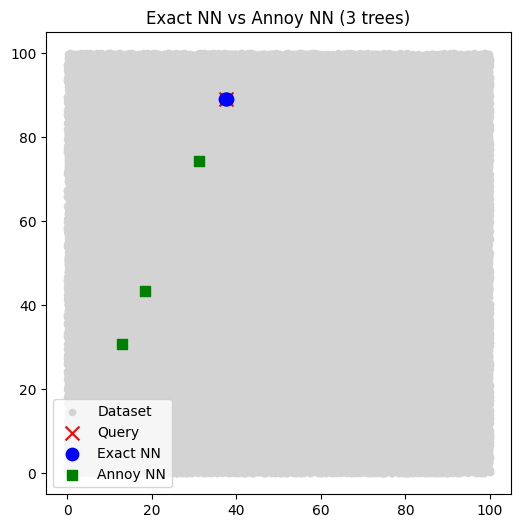

In [5]:
# 4. Visualisasi hasil
plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], c="lightgray", s=20, label="Dataset")
plt.scatter(query[0], query[1], c="red", marker="x", s=100, label="Query")

# Exact NN ditandai biru
plt.scatter(X[idx_exact,0], X[idx_exact,1], c="blue", s=80, label="Exact NN")

# Annoy NN ditandai hijau
plt.scatter(X[idx_ann,0], X[idx_ann,1], c="green", s=50, marker="s", label="Annoy NN")

plt.legend()
plt.title("Exact NN vs Annoy NN (3 trees)")
plt.show()

## Mengisi tabel percobaan

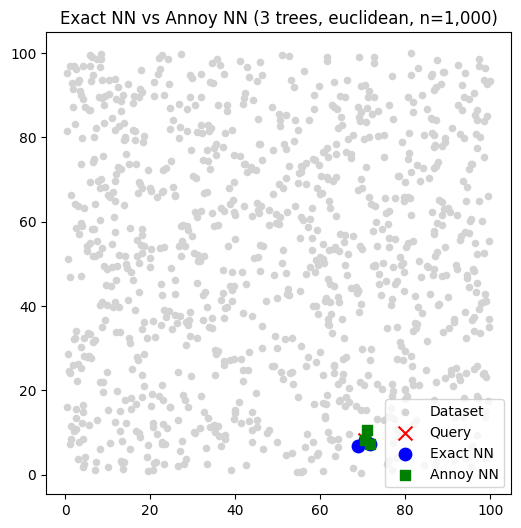

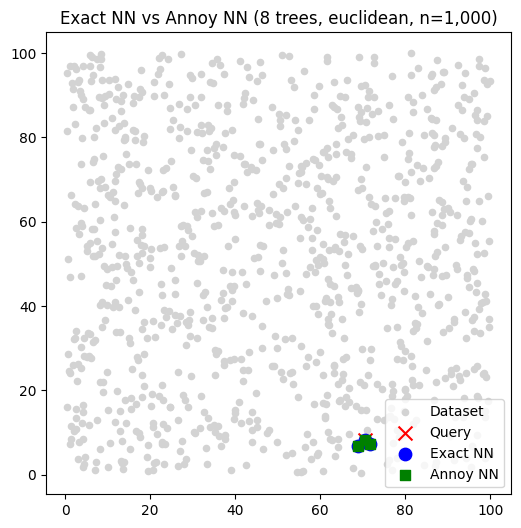

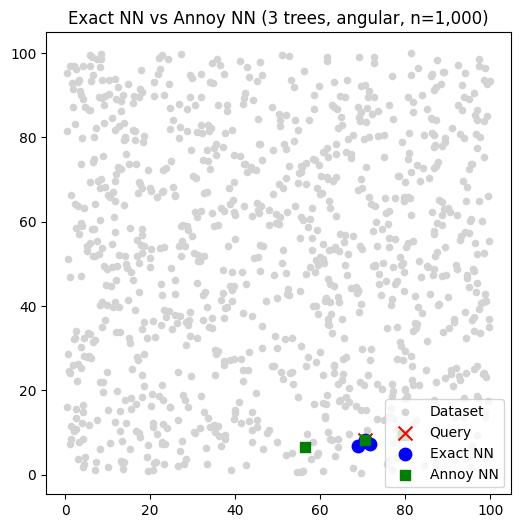

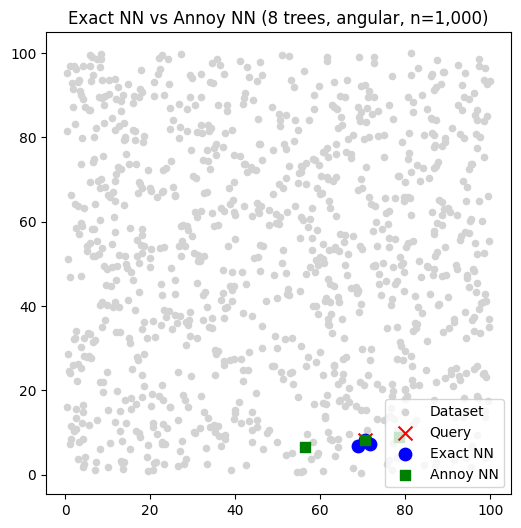

In [11]:
results = []

metrics = ['euclidean', 'angular']
trees = [3, 8]
sizes = [1000, 100000]

for metric in metrics:
    for n_tree in trees:
        for n_points in sizes:
            # 1. Dataset 2D
            np.random.seed(42)
            X = np.random.rand(n_points, 2) * 100

            # Query point (ambil salah satu titik random)
            query = X[np.random.randint(0, n_points)]

            # 2. Exact NN (brute force)
            start = time.time()
            dist = np.linalg.norm(X - query, axis=1)
            idx_exact = np.argsort(dist)[:3]
            time_exact = time.time() - start

            # 3. Annoy NN
            t = AnnoyIndex(2, metric)
            for i, v in enumerate(X):
                t.add_item(i, v)
            t.build(n_tree)
            start = time.time()
            idx_ann = t.get_nns_by_vector(query, 3)
            time_ann = time.time() - start

            # 4. Visualisasi hasil
            if n_points <= 5000:
                plt.figure(figsize=(6,6))
                plt.scatter(X[:,0], X[:,1], c="lightgray", s=20, label="Dataset")
                plt.scatter(query[0], query[1], c="red", marker="x", s=100, label="Query")
                
                # Exact NN ditandai biru
                plt.scatter(X[idx_exact,0], X[idx_exact,1], c="blue", s=80, label="Exact NN")
                
                # Annoy NN ditandai hijau
                plt.scatter(X[idx_ann,0], X[idx_ann,1], c="green", s=50, marker="s", label="Annoy NN")
                
                plt.legend()
                plt.title(f"Exact NN vs Annoy NN ({n_tree} trees, {metric}, n={n_points:,})")
                plt.show()
                plt.close()

            # --- Simpan hasil ke list ---
            results.append({
                "Distance Metrics": metric.capitalize(),
                "Tree": n_tree,
                "Jumlah data": f"{n_points:,}",
                "Hasil Index terdekat ENN vs ANN": f"{[int(i) for i in idx_exact]}, {[int(i) for i in idx_ann]}",
                "Waktu komputasi Vs": f"{round(time_exact*1000,4)} , {round(time_ann*1000,4)}"
            })

# --- Convert ke DataFrame ---
df = pd.DataFrame(results)

In [12]:
# --- Tampilkan tabel rapi ---
print(df.to_string(index=False))

Distance Metrics  Tree Jumlah data              Hasil Index terdekat ENN vs ANN Waktu komputasi Vs
       Euclidean     3       1,000             [219, 898, 593], [219, 898, 770]          0.0 , 0.0
       Euclidean     3     100,000 [64040, 64186, 88792], [64040, 64186, 88792]   10.9992 , 1.0011
       Euclidean     8       1,000             [219, 898, 593], [219, 898, 593]          0.0 , 0.0
       Euclidean     8     100,000 [64040, 64186, 88792], [64040, 64186, 88792]      10.9971 , 0.0
         Angular     3       1,000             [219, 898, 593], [219, 429, 962]          0.0 , 0.0
         Angular     3     100,000  [64040, 64186, 88792], [37867, 7452, 41684]      28.9996 , 0.0
         Angular     8       1,000             [219, 898, 593], [219, 429, 540]          0.0 , 0.0
         Angular     8     100,000 [64040, 64186, 88792], [57618, 59477, 44489]      10.0026 , 0.0


# Simulasi track spotify

In [13]:
import numpy as np
import time
from sklearn.metrics.pairwise import euclidean_distances
from annoy import AnnoyIndex

# ---- 1. Buat dataset mirip Spotify ----
n_tracks = 50_000_000   # 50 juta track
n_features = 20        # contoh: danceability, energy, tempo, dll.

# dataset besar (random untuk simulasi)
X = np.random.rand(n_tracks, n_features).astype(np.float32)

# query track (misalnya lagu baru)
query = np.random.rand(1, n_features).astype(np.float32)


In [14]:
# ---- 2. Exact NN (brute force) ----
start = time.time()
distances = euclidean_distances(query, X)[0]   # hitung semua jarak
exact_idx = np.argsort(distances)[:5]          # ambil 5 terdekat
exact_time = time.time() - start

print("Exact NN result:", exact_idx)
print("Exact NN time:", round(exact_time, 3), "seconds")                                                            

Exact NN result: [ 4829797 46172387  3304359 44491395 44980244]
Exact NN time: 30.837 seconds


In [15]:
# ---- 3. Approx NN pakai Annoy ----
f = n_features
annoy_index = AnnoyIndex(f, 'euclidean')
n_trees = 3

# build index
for i in range(n_tracks):
    annoy_index.add_item(i, X[i])
annoy_index.build(n_trees)

start = time.time()
annoy_idx = annoy_index.get_nns_by_vector(query[0], 5)  # ambil 5 lagu yang mirip
annoy_time = time.time() - start

print("Annoy result:", annoy_idx)
print("Annoy time:", round(annoy_time, 3), "seconds")

Annoy result: [46860077, 37822158, 34855554, 22398111, 13925142]
Annoy time: 0.009 seconds


## Mengisi Tabel Percobaan

In [20]:
def angular_distance(a, b):
    a = np.squeeze(a)
    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b, axis=1, keepdims=True)
    cos_sim = np.dot(b, a)
    return np.arccos(np.clip(cos_sim, -1.0, 1.0)) / np.pi


In [21]:
results = []

metrics = ['euclidean', 'angular']

# ---- 1. Buat dataset ----
n_tracks = 1_000_000   # 1 juta data
n_features = 20        # contoh: danceability, energy, tempo, dll.

# dataset besar (random untuk simulasi)
X = np.random.rand(n_tracks, n_features).astype(np.float32)

# query track (misalnya lagu baru)
query = np.random.rand(1, n_features).astype(np.float32)

for metric in metrics:
    # ---- 2. Exact NN (brute force) ----
    start = time.time()
    distances = euclidean_distances(query, X)[0] if metric == 'euclidean' else angular_distance(query, X) # hitung semua jarak
    exact_idx = np.argsort(distances)[:5]          # ambil 5 terdekat
    exact_time = time.time() - start
    
    # ---- 3. Approx NN pakai Annoy ----
    f = n_features
    annoy_index = AnnoyIndex(f, metric)
    n_trees = 3
    
    # build index
    for i in range(n_tracks):
        annoy_index.add_item(i, X[i])
    annoy_index.build(n_trees)
    
    start = time.time()
    annoy_idx = annoy_index.get_nns_by_vector(query[0], 5)  # ambil 5 lagu yang mirip
    annoy_time = time.time() - start

    # --- Simpan hasil ke list ---
    results.append({
        "Distance Metrics": metric.capitalize(),
        "Tree": n_trees,
        "Jumlah data": f"{n_tracks:,}",
        "Hasil Index terdekat ENN vs ANN": f"{[int(i) for i in exact_idx]}, {[int(i) for i in annoy_idx]}",
        "Waktu komputasi Vs": f"{round(exact_time, 3)} , {round(annoy_time, 3)}"
    })

# --- Convert ke DataFrame ---
df = pd.DataFrame(results)

In [22]:
 # --- Tampilkan tabel rapi ---
print(df.to_string(index=False))

Distance Metrics  Tree Jumlah data                                                 Hasil Index terdekat ENN vs ANN Waktu komputasi Vs
       Euclidean     3   1,000,000 [8635, 811511, 730648, 287548, 933064], [811511, 433234, 137875, 206299, 30821]        0.266 , 0.0
         Angular     3   1,000,000   [8635, 830915, 811511, 730648, 287548], [8635, 830915, 607780, 21665, 280620]        0.174 , 0.0


## Pertanyaan

Kenapa code dibagian build index tidak dihitung waktunya?

- Karena penghitungan time (start) dilakukan setelah build index